In [ ]:
import os
import cv2
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

/home/takayuki/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
data_dir = '/home/takayuki/Desktop/sem6/DL/mini_proj_TRAFFIC/data/'

train_table = pd.read_csv(data_dir + 'Train.csv')
test_table = pd.read_csv(data_dir + 'Test.csv')
meta_table = pd.read_csv(data_dir + 'Meta.csv')

train_table.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


# Exploring Class Imbalance in the Dataset

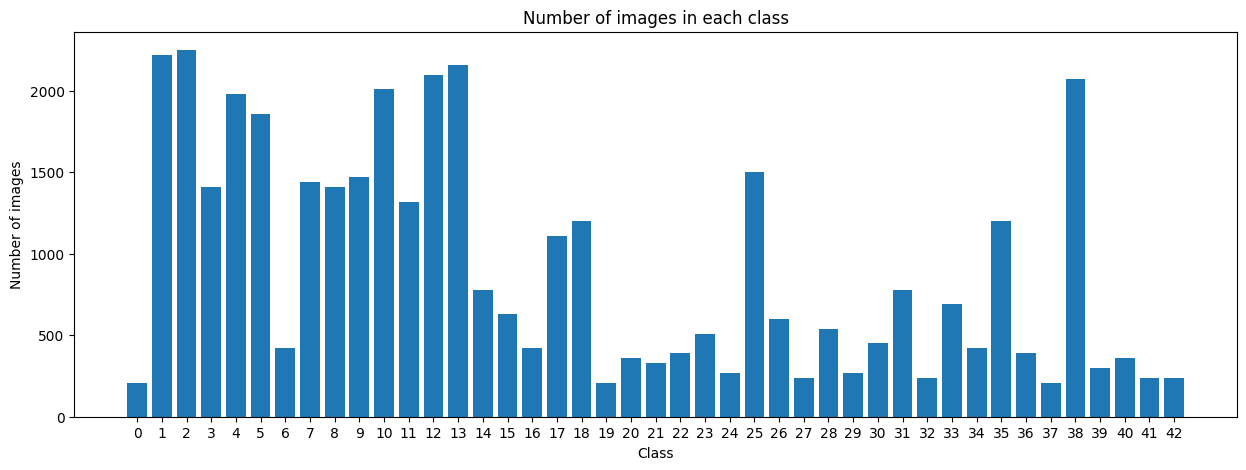

In [3]:
# Let's find out the number of images in each class
class_dict = {}
train_dir = os.path.join(data_dir, 'Train')
for folder in sorted(os.listdir(train_dir), key = lambda x: int(x)):
    class_dict[int(folder)] = len(os.listdir(os.path.join(train_dir, folder)))

plt.figure(figsize=(15, 5))
plt.xticks(range(0, 43))
plt.bar(class_dict.keys(), class_dict.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images in each class')
plt.show()

In [4]:
# sample images dictionary
sample_image_paths = {}
for row in meta_table.iterrows():
    sample_image_paths[row[1]['ClassId']] = os.path.join(data_dir, row[1]['Path'])


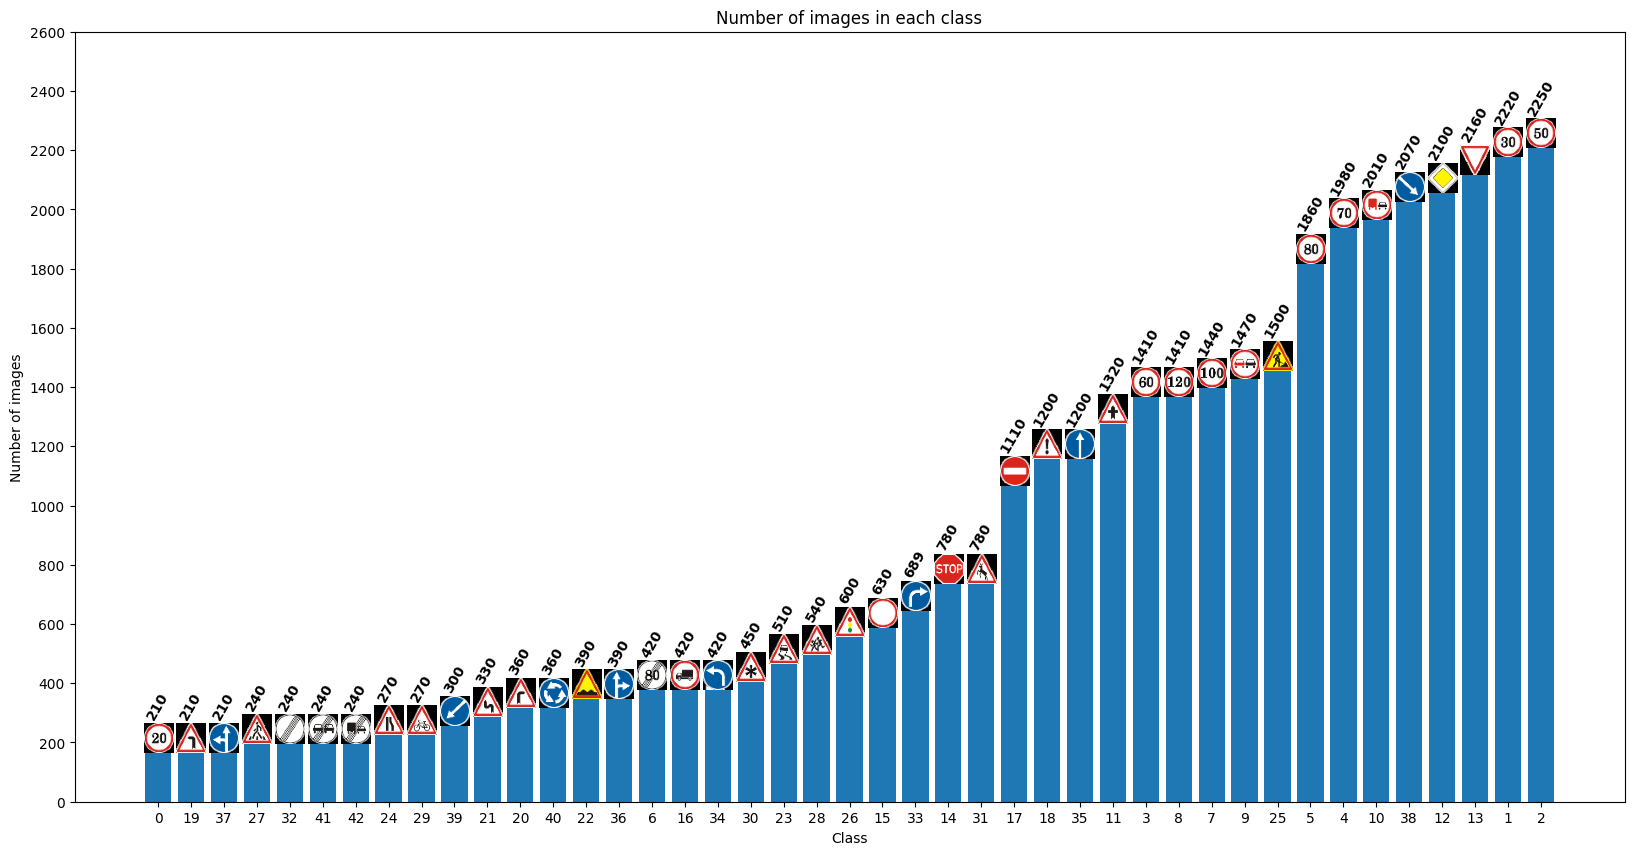

In [33]:
# sorted class_dict
sorted_class_dict = dict(sorted(class_dict.items(), key = lambda x: x[1]))

plt.figure(figsize=(20, 10))
bars = plt.bar(list(map(str, sorted_class_dict.keys())), sorted_class_dict.values())

def add_images_and_labels(ax, bars):
    """ Adds both images and numerical labels on top of bars """
    for bar, class_id in zip(bars, sorted_class_dict.keys()):
        height = bar.get_height()


        # Add image above bar 
        if class_id in sample_image_paths:
            img_path = sample_image_paths[class_id]

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (35, 35))  # Adjust size as needed

            imagebox = OffsetImage(img, zoom=0.6)
            ab = AnnotationBbox(imagebox, 
                                (bar.get_x() + bar.get_width() / 2, height + 5),  
                                frameon=False, xycoords='data', boxcoords="data", pad=0)

            ax.add_artist(ab)
        
        # Add value label above bar
        ax.text(bar.get_x() + bar.get_width() / 2, height + 60,  
                f'{height}', ha='center', va='bottom', fontsize=10, 
                rotation=60, fontweight='bold', color='black')

# Get current axes and apply function
ax = plt.gca()
add_images_and_labels(ax, bars)

plt.title('Number of images in each class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.yticks(range(0, 2800, 200))
plt.show()


We observe that the dataset suffers from a massive class imbalance. The number of samples in the majority class is 10 times the number of samples in the minority class. This imbalance can lead to poor performance of the models.
Many less common, but critically important traffic signs are underrepresented in the dataset. 

In [17]:
train_table.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


# Exploring the dimensionality of the dataset

In [18]:
max_widht = train_table['Width'].max()
max_height = train_table['Height'].max()
min_widht = train_table['Width'].min()
min_height = train_table['Height'].min()

print(f'Max width: {max_widht}, Max height: {max_height}')
print(f'Min width: {min_widht}, Min height: {min_height}')

Max width: 243, Max height: 225
Min width: 25, Min height: 25


In [19]:
avg_width = train_table['Width'].mean()
avg_height = train_table['Height'].mean()

print(f'Average width: {avg_width}, Average height: {avg_height}')

Average width: 50.83587951745773, Average height: 50.328929582493814


- We observe that the dimensions of the images vary from 25x25 to 243x225.
- The images are not of the same size. We need to resize the images to a common size before feeding them to the model.
- The average size of the images is 50x50.
- We can resize all the images to 48x48 for uniformity.

In [21]:
train_table['Roi.width'] = train_table['Roi.X2'] - train_table['Roi.X1']
train_table['Roi.height'] = train_table['Roi.Y2'] - train_table['Roi.Y1']

train_table['Roi.width'].describe()


count    39209.000000
mean        39.197786
std         21.821369
min         15.000000
25%         24.000000
50%         33.000000
75%         47.000000
max        203.000000
Name: Roi.width, dtype: float64

In [23]:
min_roi_width = train_table['Roi.width'].min()
max_roi_width = train_table['Roi.width'].max()
avg_roi_width = train_table['Roi.width'].mean()

min_roi_height = train_table['Roi.height'].min()
max_roi_height = train_table['Roi.height'].max()
avg_roi_height = train_table['Roi.height'].mean()

print(f'Max ROI width: {max_roi_width}, Max ROI height: {max_roi_height}')
print(f'Min ROI width: {min_roi_width}, Min ROI height: {min_roi_height}')
print(f'Average ROI width: {avg_roi_width: .2f}, Average ROI height: {avg_roi_height: .2f}')

Max ROI width: 203, Max ROI height: 185
Min ROI width: 15, Min ROI height: 15
Average ROI width:  39.20, Average ROI height:  38.77


- Actually cropping all the images to a desired ROI is better for our purpose, as sign detection can be treated as a separate upstream task.
- So the images can be cropped to a 32x32 region specified in the dataset's csv files.

# Exploring the images in the dataset

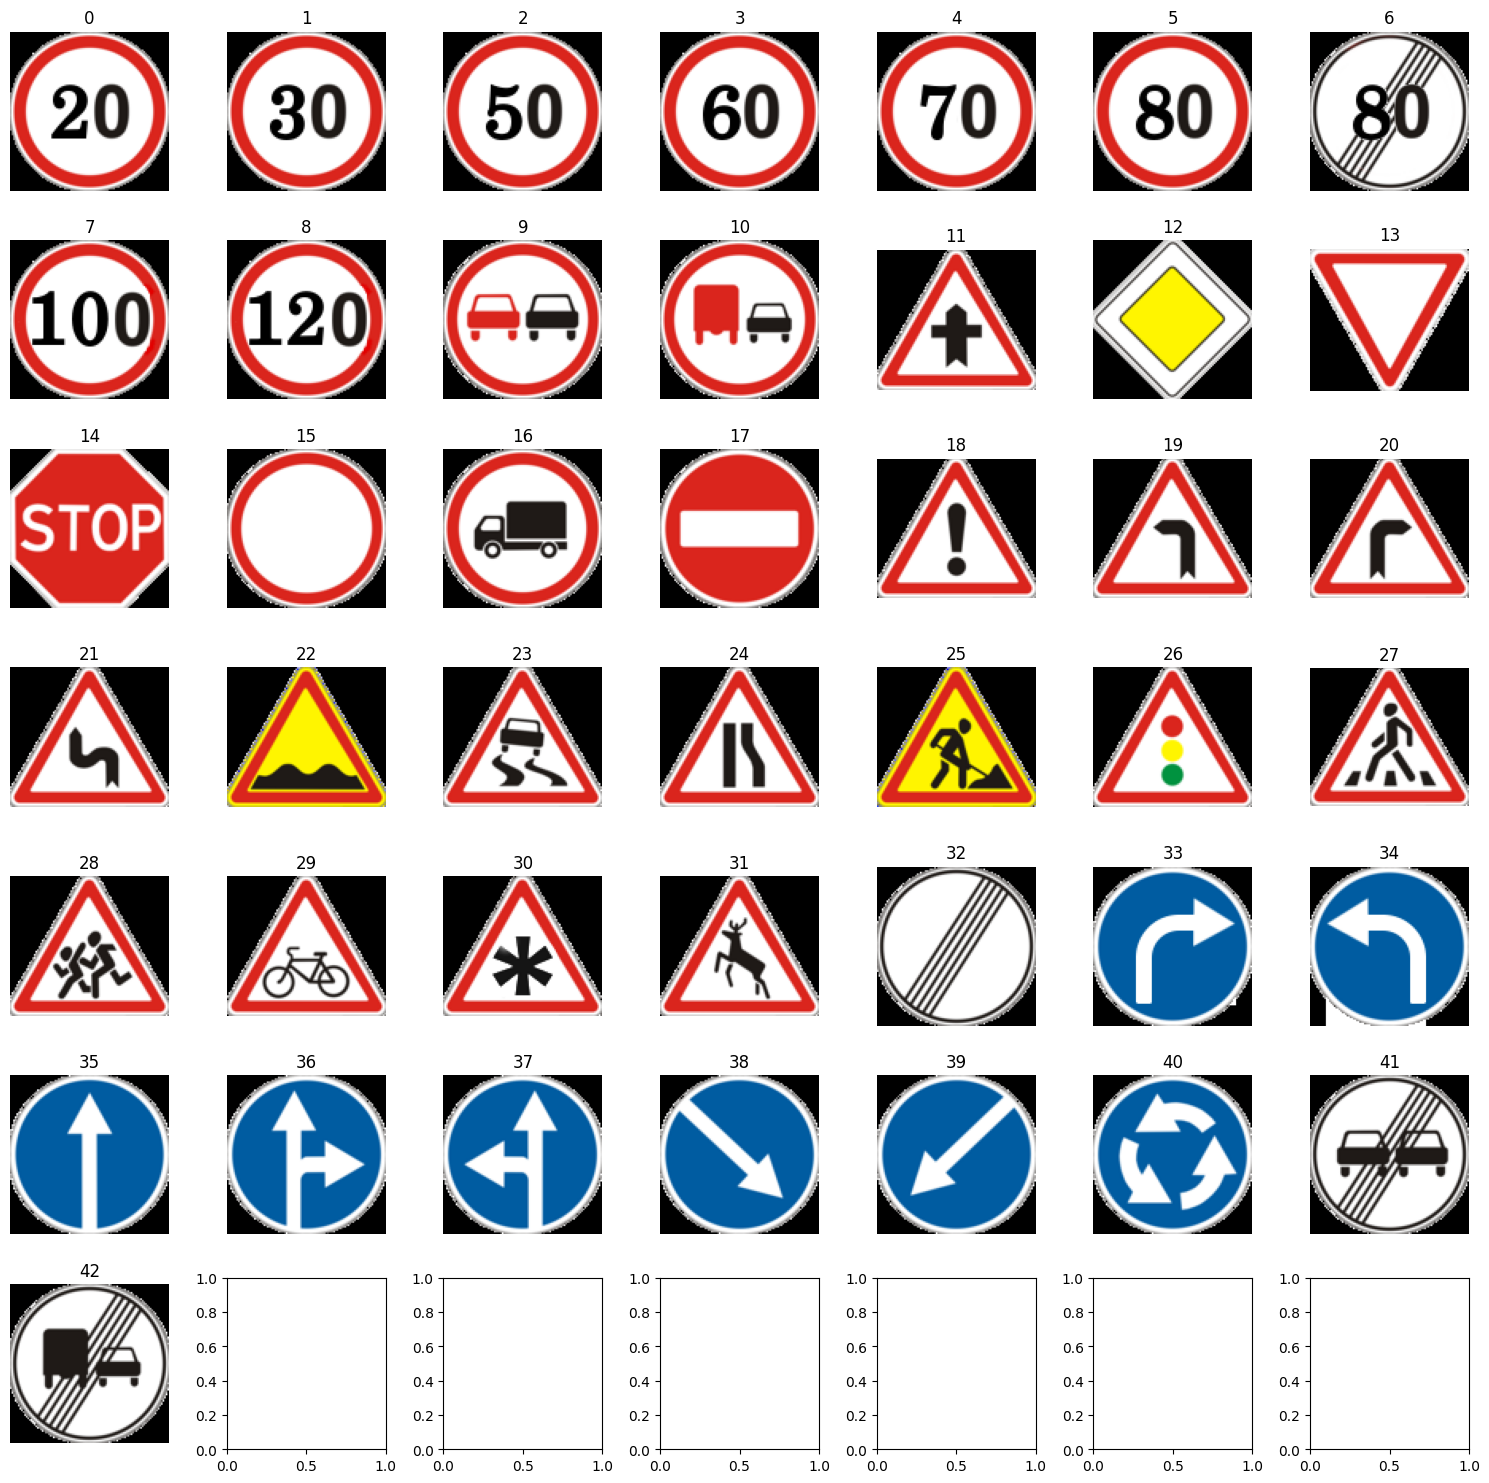

In [25]:
# Let's see all the images in the meta
# 43 images = grid of 7x7
fig, axes = plt.subplots(7, 7, figsize=(15, 15))
axes = axes.ravel()

for id, path in sample_image_paths.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[id]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(id)

plt.tight_layout()
plt.show()

- The images in the meta folder are the ideal printed images of the traffic signs.
- Let's explore images in the test folder to see the real world images of the traffic signs.

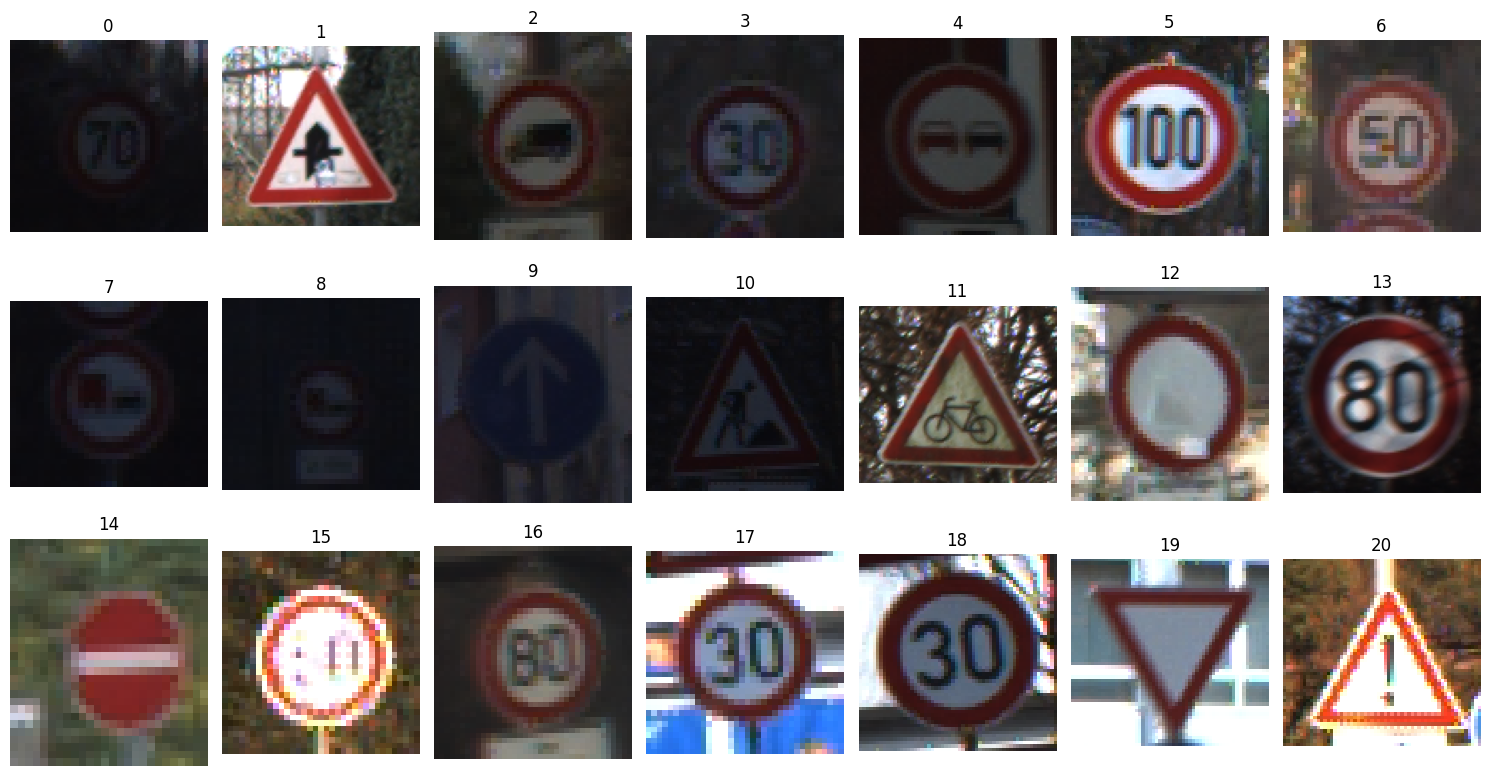

In [31]:
test_dir = os.path.join(data_dir, 'Test')

fig, axes = plt.subplots(3, 7, figsize=(15, 8))
axes = axes.ravel()

for i, img in enumerate(os.listdir(test_dir)[:21]):
    img_path = os.path.join(test_dir, img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(i)

plt.tight_layout()
plt.show()


- Let's now look at different examples of the speed limit 20 sign (class id = 0), which is the minority class in the dataset.

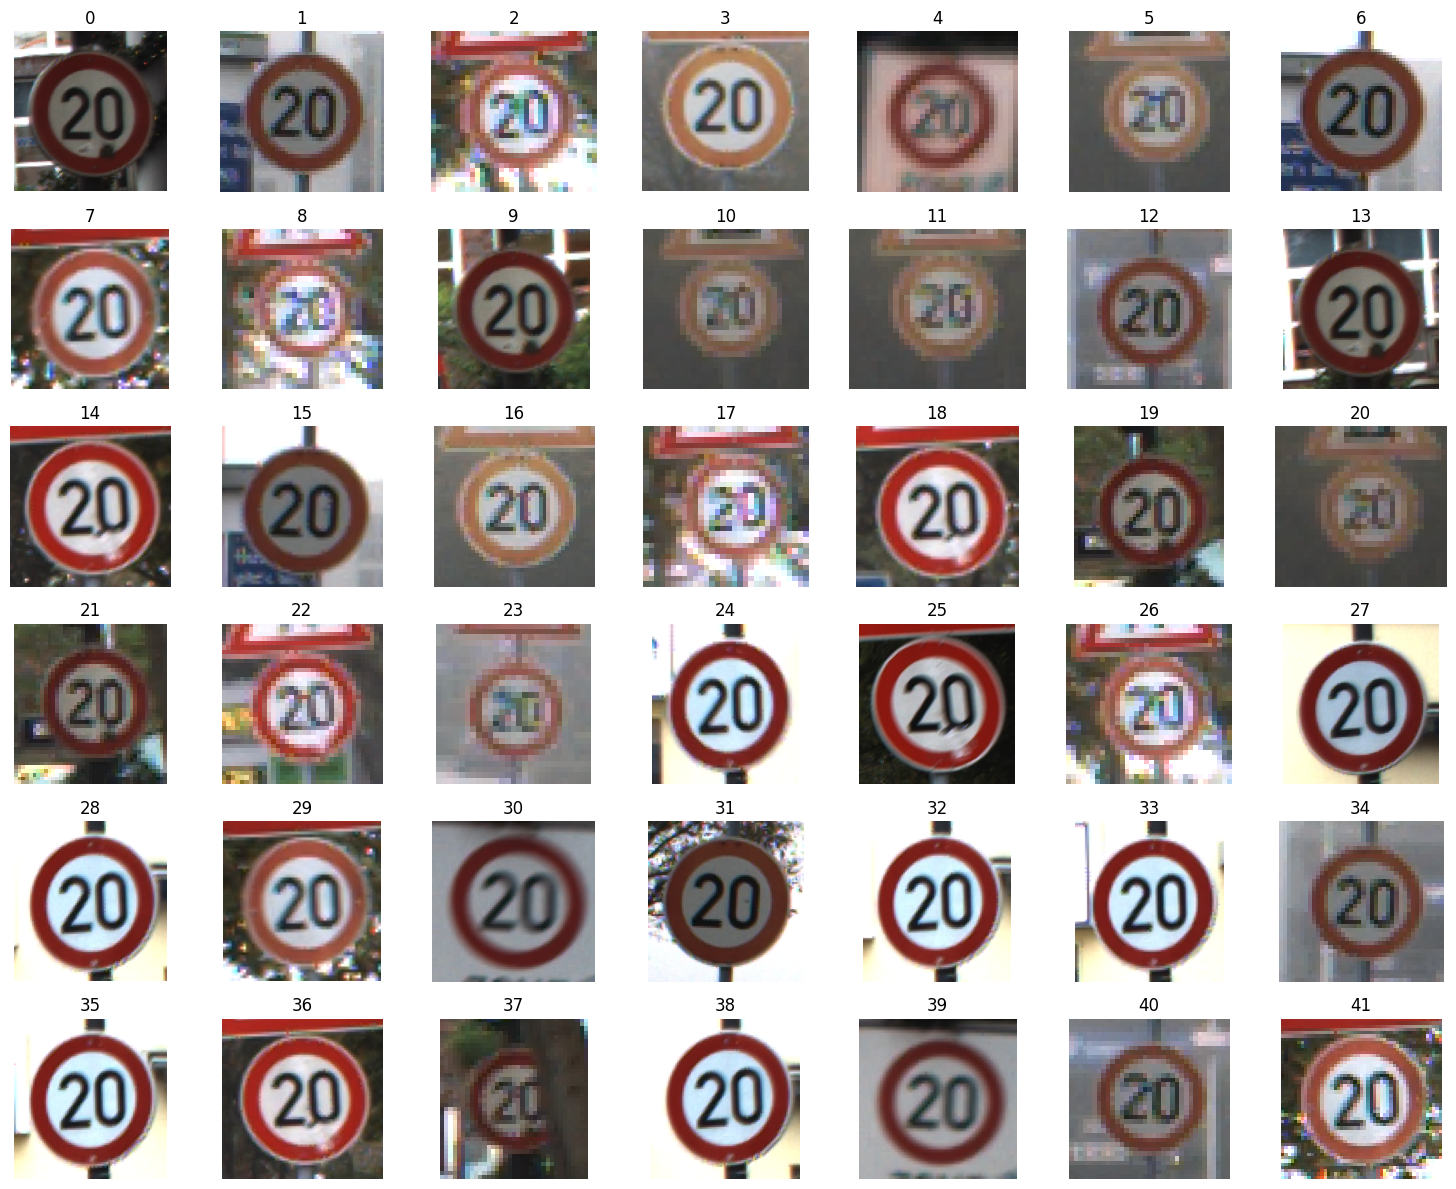

In [35]:
train0_dir = os.path.join(train_dir, '0')

fig, ax = plt.subplots(6, 7, figsize=(15, 12))
ax = ax.ravel()
for i, img in enumerate(os.listdir(train0_dir)[:42]):
    img_path = os.path.join(train0_dir, img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(i)

plt.tight_layout()
plt.show()

- We observe that there can be a lot of variation in the images of the same class. This can make the classification task challenging.
- Preprocessing the images to make them more uniform can help in improving the performance of the model.
- Preprocessing techniques that can be used:
    - Resizing and Cropping to ROI
    - Adaptive Histogram Equalization

- Our objective is to use a GAN to generate synthetic data.
- If a model is going to be trained on preprocessed, normalized images, we might as well train a GAN after pre-processing.
- But we can also explore the possibility of getting more real-world data by having the GAN learn the distribution before pre-processing.
